In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from src.scoring import rps
from src.strategy import get_weight_from_predictions
from sklearn.ensemble import RandomForestClassifier


In [3]:
universe = pd.read_csv("../data/M6_Universe.csv", index_col=0)

In [4]:
RELOAD = True
START_TEST = "2019-01-01"

In [5]:
if RELOAD:
    all_stocks_hist = pd.DataFrame()
    for iid in tqdm(universe.index):
        ticker = universe.loc[iid, "symbol"]
        stock = yf.Ticker(ticker)
        hist = stock.history(period="max")
        all_stocks_hist[ticker] = hist.stack()
    all_stocks_hist.to_pickle("../data/stocks_hist.pkl")
else:
    all_stocks_hist = pd.read_pickle("../data/stocks_hist.pkl")

In [6]:
closing_prices = all_stocks_hist.unstack(-1).swaplevel(axis=1)["Close"].bfill()  # backfilling price
daily_change = closing_prices.pct_change().fillna(0)
daily_change = daily_change.where(daily_change.abs() < .9).interpolate()  # correct for crazy errors
closing_prices = closing_prices.iloc[0] * (1+daily_change).cumprod()

closing_prices.columns.name = "symbol"
daily_test_index = closing_prices.loc[START_TEST:].index
daily_returns = np.log(1 + closing_prices.pct_change().dropna())
monthly_returns = daily_returns.resample("MS").sum()
monthly_vol = closing_prices.resample("MS").std() / closing_prices.resample("MS").mean()
monthly_quintiles = monthly_returns.apply(lambda x: (x.rank(ascending=True) // 20 +1).clip(upper=5)).astype(int)

In [8]:
window_len = 6
X = pd.concat([monthly_quintiles.shift(i+1).stack() for i in range(window_len)], axis=1).dropna()
y = monthly_quintiles.stack().reindex(X.index)

In [9]:
categories = pd.get_dummies(universe.set_index("symbol")["GICS_sector/ETF_type"])

In [10]:
names = pd.get_dummies(universe["symbol"])
names.index = universe["symbol"]

In [11]:
X = X.join(categories)#.join(names)

In [12]:
X_train = X.unstack().loc[:START_TEST].stack()
X_test = X.unstack().loc[START_TEST:].stack()
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_train.columns.astype(str)

y_train = y.unstack().loc[:START_TEST].stack()
y_test = y.unstack().loc[START_TEST:].stack()

In [13]:
mdl_forest = RandomForestClassifier(n_estimators=2000, max_depth=None, min_samples_leaf=100, random_state=0)
mdl_forest.fit(X_train, y_train)

mdl_forest.score(X_train, y_train), mdl_forest.score(X_test, y_test)

(0.34701492537313433, 0.3497368421052632)

In [14]:
proba_forest = pd.DataFrame(mdl_forest.predict_proba(X_test), index=X_test.index, columns=range(1, 6))

weights = get_weight_from_predictions(proba_forest, 5, cutoff=0.011)
daily_weights = weights.resample("d").pad().reindex(daily_test_index).ffill()
portfolio_returns = (daily_weights * (1 + closing_prices.pct_change().loc[daily_test_index])).sum(axis=1)

In [15]:
market_returns = (1 + closing_prices.pct_change().loc[daily_test_index]).mean(axis=1)

<AxesSubplot:xlabel='Date'>

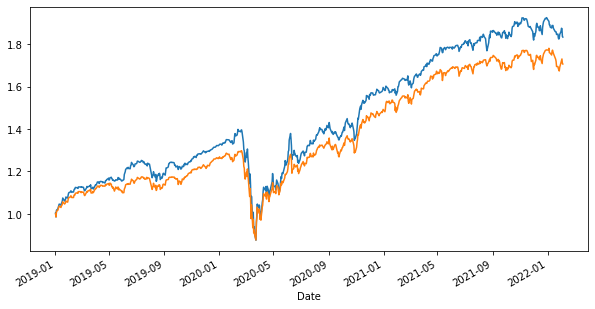

In [16]:
portfolio_returns.cumprod().plot(figsize=(10, 5))
market_returns.cumprod().plot()

In [17]:
print(f"Outperforming the market by {(100 * (portfolio_returns.prod() - market_returns.prod())).round(2)} %")

Outperforming the market by 12.69 %


In [18]:
X_sub = X_test.loc["2022-02-01"]

In [19]:
proba_submission = pd.DataFrame(mdl_forest.predict_proba(X_sub), index=X_sub.index, columns=range(1, 6))

In [20]:
proba_submission

1         2         3         4         5
Date       symbol                                                  
2022-02-01 ABBV    0.143246  0.187950  0.250341  0.181407  0.237056
           ACN     0.139017  0.190257  0.172941  0.181584  0.316200
           AEP     0.141066  0.201382  0.220245  0.185879  0.251428
           AIZ     0.132412  0.179314  0.173150  0.178205  0.336919
           ALLE    0.132251  0.170367  0.190347  0.182851  0.324183
...                     ...       ...       ...       ...       ...
           XLP     0.149693  0.202234  0.187960  0.172571  0.287542
           XLU     0.141752  0.193081  0.168456  0.178443  0.318268
           XLV     0.137286  0.189640  0.165342  0.180050  0.327682
           XLY     0.146240  0.185853  0.236415  0.149858  0.281634
           XOM     0.170113  0.200511  0.195145  0.205360  0.228871

[100 rows x 5 columns]

In [21]:
weights = get_weight_from_predictions(proba_submission, 5, cutoff=0.011)

In [22]:
sub_df = pd.concat([proba_submission, weights.stack()], axis=1).reset_index(1)
sub_df.columns = pd.read_csv("../data/template.csv").columns

In [32]:
sub_df.to_csv(f"../data/edo-gin-{pd.to_datetime('now').strftime('%m%d%H%M')}.csv", index=False)